In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from glob import glob
import warnings
warnings.filterwarnings(action='ignore')

In [8]:
img_path = '../input/flickr8k-sau/Flickr_Data/Images/'
imgs = glob(img_path + '*.jpg')
len(imgs)

8091

In [5]:
#showing 5 Im

for img in imgs[:5]:
    plt.figure()
    img = cv.imread(img)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)

In [6]:
import tensorflow as tf
# import keras
from tensorflow.keras.applications.resnet import ResNet50
pre = ResNet50(include_top = True)

2022-12-14 10:15:29.132188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 10:15:29.210465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 10:15:29.211241: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 10:15:29.212510: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [7]:
#since we dont want dense output layer we remove it
from tensorflow.keras.models import Model
last = pre.layers[-2].output
modele = Model(inputs=pre.input, outputs=last)

# model.summary()

In [8]:
#Image preprocessing
images = dict()
for i in range(len(imgs[:])):
    img = cv.imread(imgs[i])
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (224, 224))
    img = img.reshape(1, 224, 224, 3)
    pred = modele.predict(img).reshape(2048, )
    img_name = imgs[i].split('/')[-1]
    images[img_name] = pred
    

2022-12-14 10:15:33.447712: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-14 10:15:34.978850: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [9]:
#text preprocess
captions = open('../input/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt', 'rb').read().decode('utf-8').split('\n')
caption = dict()
for cap in captions:
    try:
        im = cap.split('\t')[0][:-2]
        ca = cap.split('\t')[1]
        if im in images:
            if im in caption:
                caption[im].append(ca)
            else:
                caption[im] = [ca]
    except:
        pass

    
for image, capt in caption.items():
    for i in range(len(capt)):
        caption[image][i] = 'start ' + capt[i] + ' end'

In [11]:
#Total Unique Words
count_words = {}
count =1 
for img, capts in caption.items():
    for capt in capts:
        for word in capt.split():
            if word not in count_words:
                count_words[word] = count
                count+=1

In [12]:
#Word Vectorizing
for img, capts in caption.items():
    for capt in capts:
        encoded=[]
        for word in capt.split():
                encoded.append(count_words[word])
        caption[img][capts.index(capt)] = encoded   
  
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [14]:
#Caption of Maximum length
max = 0
for img, capts in caption.items():
    for capt in capts:
        if len(capt)>max:
            max = len(capt)

In [15]:
##Preparing Inputs
# X->Image
# y_in = input sequence of words
# y_out = output word from image(X) and input sequence(y_in)

vocab = len(count_words)
def datagenerator(photo, caption):
    X = []
    y_in = []
    y_out = []
    for img, capts in caption.items():
        for capt in capts:
            for i in range(1, len(capt)):
                X.append(photo[img])
                
                in_seq = [capt[:i]]
                out_word = capt[i]
                
                in_seq = pad_sequences(in_seq, maxlen = max, padding = 'post', truncating = 'post')[0]
                out_word = to_categorical([out_word], num_classes = vocab+1)[0]
                
                y_in.append(in_seq)
                y_out.append(out_word)
                
    return X, y_in, y_out

X, y_in, y_out = datagenerator(images, caption)
X = np.array(X)
y_in = np.array(y_in, dtype = 'float64')
y_out = np.array(y_out, dtype = 'float64')

In [19]:
# libraries for Model building
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Embedding
from tensorflow.keras.layers import Dense, Flatten, Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector, Concatenate
from keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint

In [1]:
#Model Building
embedding_size = 128
max_len = max

# image_model
image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape = (2048, ), activation = 'relu'))
image_model.add(RepeatVector(max_len))

# language_model
language_model = Sequential()
language_model.add(Embedding(input_dim = vocab+1, output_dim = embedding_size, input_length = max_len))
language_model.add(LSTM(256, return_sequences = True))
language_model.add(TimeDistributed(Dense(embedding_size)))

combined = Concatenate()([image_model.output, language_model.output])

x = LSTM(128, return_sequences = True)(combined)
x = LSTM(512, return_sequences = False)(x)
x = Dense(vocab+1)(x)
out = Activation('softmax')(x) 

model = Model(inputs = [image_model.input, language_model.input], outputs = out)

model.compile(loss = 'categorical_crossentropy', optimizer = 'RMSprop', metrics = ['accuracy'])
model.summary()


SyntaxError: invalid syntax (3445894469.py, line 8)

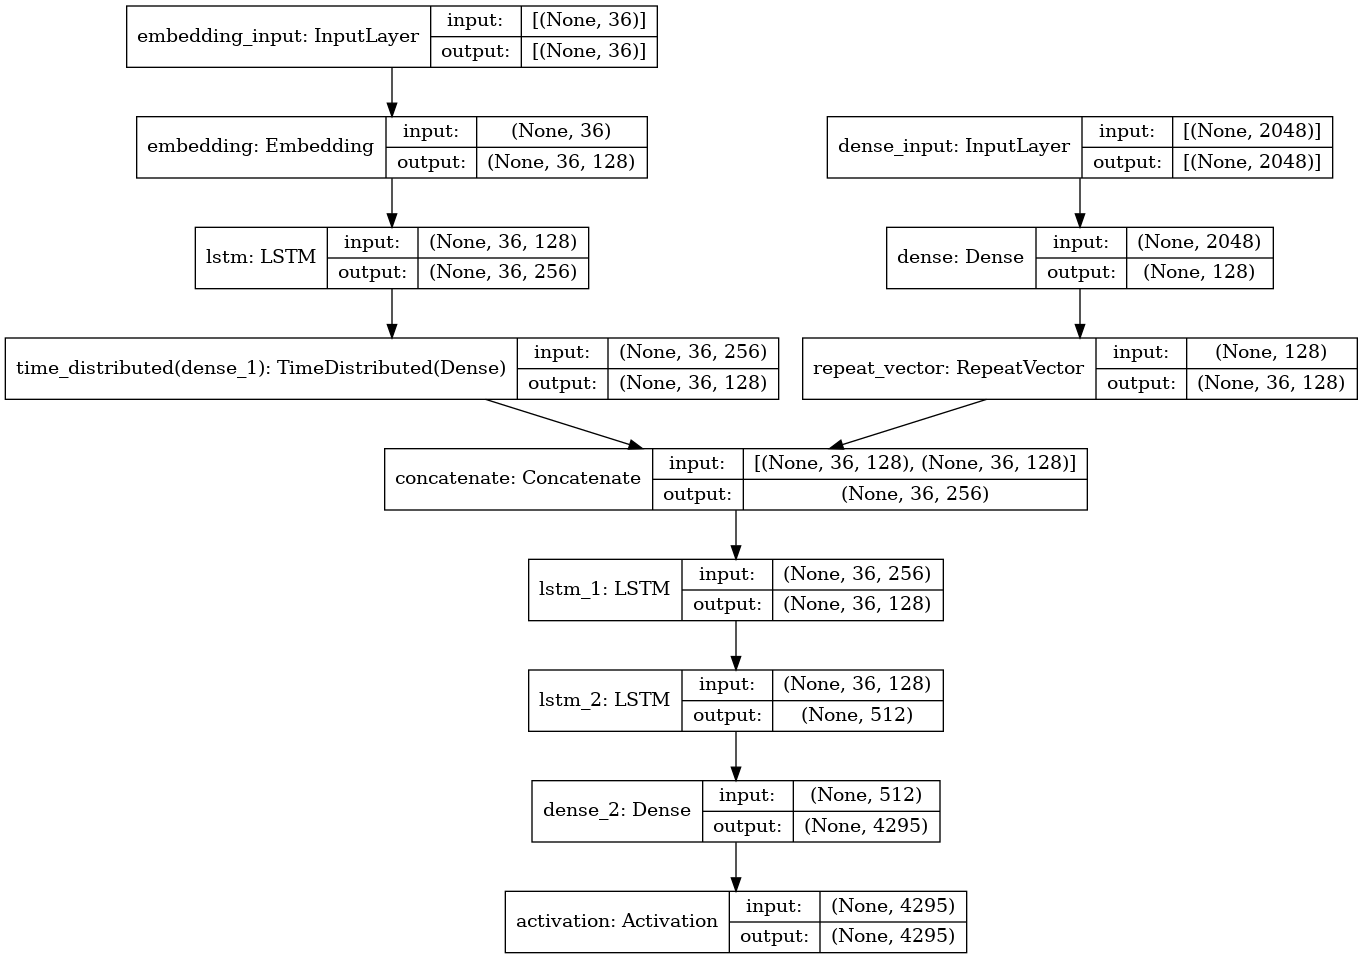

In [21]:
plot_model(model, show_shapes = True)

In [48]:
model.fit([X, y_in], y_out, batch_size = 512, epochs = 30)

2022-12-14 10:27:58.455102: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1658351040 exceeds 10% of free system memory.
2022-12-14 10:28:01.678867: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1658351040 exceeds 10% of free system memory.


Epoch 1/30
189/189 [==============================] - 12s 62ms/step - loss: 2.5167 - accuracy: 0.4582
Epoch 2/30
189/189 [==============================] - 12s 61ms/step - loss: 2.4482 - accuracy: 0.4713
Epoch 3/30
189/189 [==============================] - 12s 62ms/step - loss: 2.3806 - accuracy: 0.4806
Epoch 4/30
189/189 [==============================] - 12s 62ms/step - loss: 2.3180 - accuracy: 0.4911
Epoch 5/30
189/189 [==============================] - 12s 62ms/step - loss: 2.2548 - accuracy: 0.4994
Epoch 6/30
189/189 [==============================] - 12s 61ms/step - loss: 2.1899 - accuracy: 0.5090
Epoch 7/30
189/189 [==============================] - 12s 61ms/step - loss: 2.1250 - accuracy: 0.5204
Epoch 8/30
189/189 [==============================] - 12s 62ms/step - loss: 2.0727 - accuracy: 0.5286
Epoch 9/30
189/189 [==============================] - 11s 61ms/step - loss: 2.0164 - accuracy: 0.5386
Epoch 10/30
189/189 [==============================] - 11s 61ms/step - loss: 1.958

In [50]:
#Evaluation
inv_dict = {v:k for k, v in count_words.items()}
def getImage(ind):
    img = cv.imread(imgs[ind])
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (224, 224))
    img  = img.reshape((1, 224, 224, 3))
    return img  

test_img = getImage(4500)
test_feature = modele.predict(test_img).reshape(1, 2048)

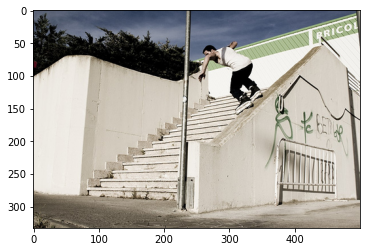

In [9]:
#test image
img = cv.imread(imgs[4500])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

In [62]:
# Predicting Output
text_inp = ['start']
count =0
caption = ''
while count<25:
    count += 1
    encoded = []
    for i in text_inp:
        encoded.append(count_words[i])
    encoded = [encoded]
    encoded = pad_sequences(encoded, padding = 'post', truncating = 'post', maxlen = max_len)
    prediction = np.argmax(model.predict([test_feature, encoded]))
#     print(prediction)
    sampled_word = inv_dict[prediction]
    caption = caption + " "+ sampled_word
    if sampled_word == 'end':
        break
    text_inp.append(sampled_word)                      

In [63]:
caption

' A skateboarder is performing a trick in the air . end'